# InceptionV3-fine-tune

### Import pkgs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import os
import time
import zipfile
import pickle
from PIL import Image
from shutil import copy2

### Run name

In [2]:
project_name = 'dog-breed-identification'
step_name = 'InceptionV3-fine-tune'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d-%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: dog-breed-identification_InceptionV3-fine-tune_20180115-224139


### Basic folders

In [3]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)



input_path: D:\Kaggle\dog-breed-identification\input
log_path: D:\Kaggle\dog-breed-identification\log
model_path: D:\Kaggle\dog-breed-identification\model
output_path: D:\Kaggle\dog-breed-identification\output


### Build model

In [4]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Input
from keras.layers.merge import Concatenate
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

from keras.applications.vgg19 import VGG19, preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2

Using TensorFlow backend.


In [5]:
def build_model():
    base_model = VGG19(weights='imagenet', include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(120, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)

    for layer in model.layers[:249]:
       layer.trainable = False
    for layer in model.layers[249:]:
       layer.trainable = True
    
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [6]:
model = build_model()
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [7]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
# saveModel(model, 'saveModel_test')

In [8]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.995 ** x)

# def get_lr(x):
#     lr = round(1e-4 * 0.995 ** x, 6)
#     if lr < 5e-5:
#         lr = 5e-5
#     print(lr, end='  ')
#     return lr
# annealer = LearningRateScheduler(get_lr)

# log_dir = os.path.join(log_path, run_name)
# print('log_dir:' + log_dir)
# tensorBoard = TensorBoard(log_dir=log_dir)

callbacks = [annealer]

In [9]:
batch_size = 8

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range = 20,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True,
    vertical_flip = True
)
train_generator = train_datagen.flow_from_directory(
    './input/data_train',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode = "categorical",
    seed=2018
)
print(train_generator.classes)

val_datagen = ImageDataGenerator(
    rescale=1./255
)
val_generator = val_datagen.flow_from_directory(
    './input/data_val',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode = "categorical",
    seed=2018
)
print(val_generator.classes)

Found 29779 images belonging to 120 classes.
[  0   0   0 ..., 119 119 119]
Found 1023 images belonging to 120 classes.
[  0   0   0 ..., 119 119 119]


In [10]:
%%time
hist = model.fit_generator(
    train_generator,
    steps_per_epoch=10,
    epochs=2, #Increase this when not on Kaggle kernel
    verbose=1,  #1 for ETA, 0 for silent
    callbacks=callbacks,
#     max_queue_size=256,
#     workers=32,
    validation_steps=10,
    validation_data=val_generator
)

Epoch 1/2
10/10 [==============================] - 25s 3s/step - loss: 4.8755 - acc: 0.0250 - val_loss: 4.8643 - val_acc: 0.0000e+00
Epoch 2/2
10/10 [==============================] - 21s 2s/step - loss: 4.8798 - acc: 0.0125 - val_loss: 4.8643 - val_acc: 0.0000e+00
Wall time: 46.6 s


In [12]:
# final_loss, final_acc = model.evaluate(x_val, y_val, verbose=0)
final_loss, final_acc = model.evaluate_generator(val_generator)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 4.8741, final accuracy: 0.0098


In [13]:
final_acc_str = '{0:0>4}'.format(int(final_acc*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name_acc)

dog-breed-identification_InceptionV3-fine-tune_20180115-224139_0097


In [14]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


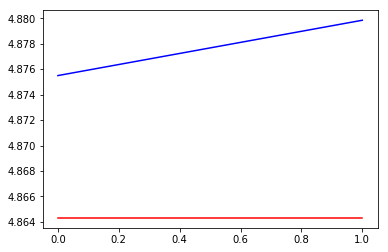

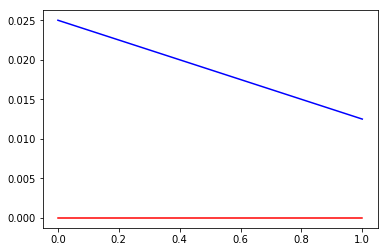

In [15]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [16]:
saveModel(model, run_name_acc)